<a href="https://colab.research.google.com/github/jjiguaran/text_mining/blob/master/ndividual_versions/sentiment_analysis_srossi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importo el dataset

In [ ]:
# Importar librerias
import pandas as pd

#Importar los datasets
url_reddit = 'https://raw.githubusercontent.com/jjiguaran/text_mining/master/Data/RedditNews.csv'
url_combined = 'https://raw.githubusercontent.com/jjiguaran/text_mining/master/Data/Combined_News_DJIA.csv'
RedditNews = pd.read_csv(url_reddit)
CombinedNews = pd.read_csv(url_combined)


RedditNews['Date'] =  pd.to_datetime(RedditNews['Date'], format='%Y-%m-%d')
CombinedNews['Date'] =  pd.to_datetime(CombinedNews['Date'], format='%Y-%m-%d')

In [ ]:
# Exploramos redditnews
RedditNews.head()

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...


In [ ]:
# Exploramos combinedNews
CombinedNews.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who k

In [ ]:
## Nos quedamos con las fechas del dataset que está etiquetado
RedditNews = RedditNews[RedditNews['Date'].isin(CombinedNews['Date'])]

print(
    CombinedNews['Date'].nunique(),
    RedditNews['Date'].nunique() )

1989 1989


# Transformacion de los datos


In [ ]:
## Hay error en la codificación de caracteres especiales, encontré ese, pero hay que ver que otros surgen
index_review = RedditNews[RedditNews['News'].str.contains('&amp;')].index
display(RedditNews[RedditNews['News'].str.contains(' us ')])
RedditNews['News'] = RedditNews['News'].str.replace('&amp;', '&')

,Date,News
24,2016-07-01,Ozone layer hole seems to be healing - US &amp...
37,2016-06-30,Japan's top court has approved blanket surveil...
204,2016-06-23,"Erdoan: Europe, you dont want us because were ..."
376,2016-06-16,Germany to end unofficial tolerance of polygam...
1762,2016-04-22,'Kindly send us names and quotes insulting our...
...,...,...
70187,2008-10-22,"b'Despite intense U.S. pressure, Pakistan refu..."
70379,2008-10-15,b'What does the rehabilitation of Bill Ayers t...
71185,2008-09-12,"b'Putin on Georgia: ""What did you want us to d..."
71830,2008-08-18,b'Putin has given us an order that everyone mu...


In [ ]:
import re
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stoplist = stopwords.words("english")
REPLACE_BY_SPACE_RE = re.compile('[(){}\[\]\|@,;-]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z ^#\+_]')
SEP_NUMBER = re.compile('(?<=\d)\,|\.(?=\d)')
USA_ABREV = re.compile('U\.S|u\.s\|u\.s\.a\.|US')
DOT_ABREV = re.compile('\.(?![a-zA-Z]{2})')
STARTING_B = re.compile("^\"b' |^b ")
STOPWORDS = stopwords.words('english')

def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    
    text = USA_ABREV.sub(' usa ', text) # replace U.S U.S. u.s US for usa
    text = text.lower() # lowercase text
    text = text.replace("al-qaeda", "alqaeda")
    text = text.replace("al-qa'eda", "alqaeda")
    text = text.replace('&amp;', '&')
    text = text.replace('&', '')    

    text = DOT_ABREV.sub('', text) # removes abrevetion dot, ej: L.G.B.T  = LGBT
    text = SEP_NUMBER.sub('', text) # removes . and , seprating numbers
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub(' ', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = STARTING_B.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text

    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    text = text.strip()
    return text
    
RedditNews['News_cleaned'] = RedditNews['News'].apply(clean_text)

In [ ]:
Combinedtest = CombinedNews.copy()
Combinedtest.fillna("" , inplace= True)
joindocuemnt = ""
for n,_ in Combinedtest.iloc[:,2:].iteritems():
    joindocuemnt = joindocuemnt + " " +Combinedtest[n].apply(clean_text)
Combinedtest["Document"] = joindocuemnt
corpus = Combinedtest["Document"].str.cat(sep=' \n')

In [ ]:
Combinedtest

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Document
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",georgia downs two russian warplanes countries...
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",wont america nato help us wont help us help i...
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",remember adorable 9 year old sang openin

# Sentiment analysis

Usamos el paquete TextBlob que clasifica oraciones según polaridad, siendo -1 máx.  negatividad y 1 maxima positividad


In [ ]:
from textblob import TextBlob

In [ ]:
testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!")
testimonial.sentiment

Sentiment(polarity=0.39166666666666666, subjectivity=0.4357142857142857)

In [ ]:
testimonial.sentiment.polarity

0.39166666666666666

Calculo sentimiento para el dataframe

In [ ]:
for i in  range(0,len(Combinedtest),1):
  for j in range(2,28):
    Combinedtest.iloc[i,j] = TextBlob(Combinedtest.iloc[i,j]).sentiment.polarity
  

In [ ]:
Combinedtest

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Document
0,2008-08-08,0,0,0,0,0.05,-0.307143,-0.0518519,0,-0.2,-0.1,0,0.0333333,0.0333333,-0.0333333,-0.125,0,0.35,0,-0.1,0.0787879,0,-0.7,0,0,-0.1,0,-0.0433816
1,2008-08-11,1,0,-0.155556,0.1,0,0,0.136364,-0.425,0.25,0.6,0,0,0.183333,0,0.136364,0,-0.4,0.25,0,0,0,0,0,0,0.5,0,0.107374
2,2008-08-12,0,0,0,-0.25,-0.875,0,0,0,0.0222222,-0.025,0,0.0380952,-0.15,0,0.214286,0.5,0.25,0.285714,-0.333333,-0.6,0,0,0,-0.2,0.136364,0,-0.00221861
3,2008-08-13,0,0,0,-0.2,-0.212963,0.175,0,0,0,0,0.5,-0.166667,0,0.133333,0,0.285714,-0.4,0,0,0,0,0,0,0,-0.1,0,0.00584215
4,2008-08-14,1,0,0,0.4,-0.233333,-0.2,-0.5,0.625,0.166667,0,-0.1,0,0.285714,0,0.55,-0.025,0.1,0,0.0666667,0,0.0681818,0,0,0,0.0625,0,0.0302602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984,2016-06-27,0,0.5,-0.25,-0.7,0,0.8,0,0.075,-0.4,-0.0833333,0,-0.116667,0,0,0,-0.1,-0.05,0.275,0,-0.25,0.136364,0.00666667,0,0,0.0340909,0.2,-0.0200159
1985,2016-06-28,1,0.525,0,0,0.4,-0.1,-1,0.125,0,0.2,-0.0518519,0,0,0.0340909,-0.166667,0.0681818,0.366667,0,0,0.0291667,0,0,0.368182,0,0,0.1,0.0440657
1986,2016-06-29,1,0,0,0,-0.0428571,-0.15,0,0.25,0,0.3,0.111429,0.25,-0.3,0,0,0,0,0.168182,0,-0.108333,0.825,0.15,-0.7,0,0,0.212121,0.0631241
1987,2016-06-30,1,0,-0.348413,0,0.133333,0,0,0,0,0,-0.15,-0.155556,0,0,-0.4,0,0.466667,0.2,0,-0.05,0.5,0.25,0,0.125,0,0,-0.00687831


Genero variable 'promtop5' con el promedio de las 5 primeras noticias

In [ ]:
Combinedtest["promtop5"]= (Combinedtest["Top1"]+Combinedtest["Top2"]+Combinedtest["Top3"]+Combinedtest["Top4"]+Combinedtest["Top5"]+Combinedtest["Top6"]+Combinedtest["Top7"])/7

Asigno positivo a ayores de .05 de polaridad, negativo a menores de -.05 y netro al resto

In [ ]:

Combinedtest['promtop5_bool'] = 'Neutral' 
Combinedtest.loc[Combinedtest["promtop5"]>.05, 'promtop5_bool'] = 'Positivo' 
Combinedtest.loc[Combinedtest["promtop5"]<=-.05, 'promtop5_bool'] = 'Negativo' 


In [ ]:
import matplotlib.pyplot as plt

No hay patron claro para la polaridad promedio del día

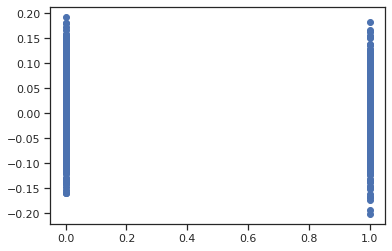

In [ ]:
plt.scatter( data=Combinedtest, x ='Label', y='Document')
plt.show()


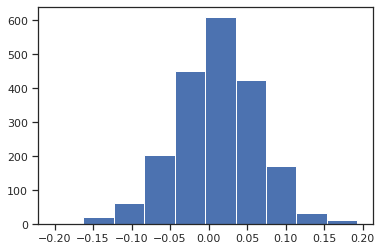

In [ ]:
plt.hist(Combinedtest.iloc[:,27])
plt.show()

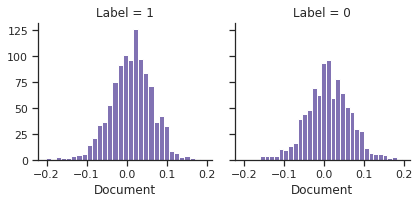

In [ ]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(Combinedtest, col="Label", col_order=[1, 0])
#g = g.map(plt.hist, "Document", bins=30, color="m")

g = g.map(plt.hist, "Document", bins=30, color="m")

## Para el top 5
Mayor presencia de días con alza en positivo y neutro

In [188]:

## Distribución de clases
import seaborn as sns

display( Combinedtest.groupby(['Label','promtop5_bool'])['Date'].agg(['count']))
#sns.countplot( x='promtop5_bool', data=Combinedtest)

count
Label promtop5_bool       
0     Negativo         168
      Neutral          465
      Positivo         291
1     Negativo         189
      Neutral          536
      Positivo         340